# Lecture 7: Dimension Reduction and Clustering

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups, load_digits
from sklearn.feature_extraction.text import TfidfVectorizer

# these are new imports for dimensionality reduction
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
# these are new imports for clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

## Dimension Reduction

### PCA

The R package [`cluster.datasets`](http://cran.r-project.org/web/packages/cluster.datasets/cluster.datasets.pdf) has some good datasets for experimenting with unsupervised learning techniques like dimensionality reduction and clustering.  Here, we'll use the `cake.ingredients.1961` dataset of cake recipes, which I've exported to a CSV.

In [3]:
cakes = pd.read_csv("./cakes.csv")
# strip trailing whitespace in the names
cakes["Cake"] = cakes.Cake.str.strip()
cakes.head()

,Cake,AE,BM,BP,BR,BS,CA,CC,CE,CI,...,SA,SC,SG,SR,SS,ST,VE,WR,YT,ZH
0,Angel,0.25,0,0.0,0.00,0,0.0,0.0,0,0,...,0.0,0,0.0,1.50,0,0.25,1,0.00,0.0,0
1,Babas au Rhum,0.00,0,0.0,0.25,0,0.0,0.0,0,0,...,0.0,0,0.0,0.25,0,0.00,0,0.25,0.6,0
2,Sweet Chocolate,0.00,0,0.0,1.00,0,0.0,0.0,4,0,...,1.0,0,0.0,2.00,0,0.50,1,0.50,0.0,0
3,Buche de Noel,0.00,0,0.0,0.00,0,0.0,0.0,0,0,...,0.0,0,0.0,1.30,0,0.50,1,0.00,0.0,0
4,Cheesecake,0.00,0,0.0,0.25,0,0.0,1.5,0,0,...,0.0,1,0.0,1.00,0,0.25,0,0.00,0.0,6


Let's store a dictionary of the ingredient abbreviations so we can look them up:

In [4]:
ingredients_dict = {
    "AE": "Almond essence",
    "BM": "Buttermilk",
    "BP": "Baking powder",
    "BR": "Butter",
    "BS": "Bananas",
    "CA": "Cocoa",
    "CC": "Cottage Cheese",
    "CE": "Chocolate",
    "CI": "Crushed Ice",
    "CS": "Crumbs",
    "CT": "Cream of tartar",
    "DC": "Dried currants",
    "EG": "Eggs",
    "EY": "Egg white",
    "EW": "Egg yolk",
    "FR": "Sifted flour",
    "GN": "Gelatin",
    "HC": "Heavy cream",
    "LJ": "Lemon juice",
    "LR": "Lemon",
    "MK": "Milk",
    "NG": "Nutmeg",
    "NS": "Nuts",
    "RM": "Rum",
    "SA": "Soda",
    "SC": "Sour cream",
    "SG": "Shortening",
    "SR": "Granulated sugar",
    "SS": "Strawberries",
    "ST": "Salt",
    "VE": "Vanilla extract",
    "WR": "Water",
    "YT": "Yeast",
    "ZH": "Zwiebach"
}

Get rid of the column of cake names so that we have a numeric only dataframe:

In [5]:
X = cakes.iloc[:, 1:]
X.head()

,AE,BM,BP,BR,BS,CA,CC,CE,CI,CS,...,SA,SC,SG,SR,SS,ST,VE,WR,YT,ZH
0,0.25,0,0.0,0.00,0,0.0,0.0,0,0,0.0,...,0.0,0,0.0,1.50,0,0.25,1,0.00,0.0,0
1,0.00,0,0.0,0.25,0,0.0,0.0,0,0,0.0,...,0.0,0,0.0,0.25,0,0.00,0,0.25,0.6,0
2,0.00,0,0.0,1.00,0,0.0,0.0,4,0,0.0,...,1.0,0,0.0,2.00,0,0.50,1,0.50,0.0,0
3,0.00,0,0.0,0.00,0,0.0,0.0,0,0,0.0,...,0.0,0,0.0,1.30,0,0.50,1,0.00,0.0,0
4,0.00,0,0.0,0.25,0,0.0,1.5,0,0,0.0,...,0.0,1,0.0,1.00,0,0.25,0,0.00,0.0,6


In [6]:
X.shape

(18, 34)

First, we'll run a simple PCA using the [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  If we don't specify `n_components` or set it to `None`, it will use the maximum number of principal components:

In [7]:
pca = PCA(n_components=None)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Let's take a look at the explained variance of each of the principal components:

In [8]:
pca.explained_variance_ratio_

array([  3.56345001e-01,   2.06756842e-01,   1.25227711e-01,
         7.81013137e-02,   6.98928608e-02,   4.38913593e-02,
         3.02923250e-02,   2.34056834e-02,   1.68109617e-02,
         1.41984207e-02,   1.04171472e-02,   7.37776655e-03,
         6.55105678e-03,   4.10397685e-03,   3.89357841e-03,
         2.02709411e-03,   7.06900749e-04,   4.42942814e-33])

And plot it:

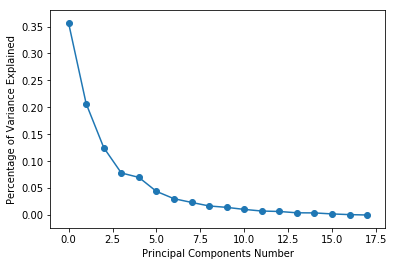

In [9]:
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.scatter(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal Components Number")
plt.ylabel("Percentage of Variance Explained")
plt.show()

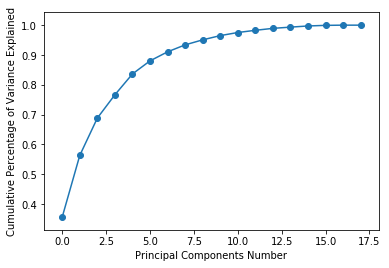

In [10]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)), cumsum)
plt.scatter(range(len(pca.explained_variance_ratio_)), cumsum)
plt.xlabel("Principal Components Number")
plt.ylabel("Cumulative Percentage of Variance Explained")
plt.show()

If we're looking for an "elbow", it looks like roughly 6 or 7 principal components would be enough.  To actually get each row transformed into the principal component space, we can call `transform` on an already fit `PCA` object, or we can do both at once with `fit_transform`:

In [11]:
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X)
X_trans

array([[ -1.50568324,   9.53055632],
       [ -0.92346393,   0.44023955],
       [ -0.90010965,  -1.28050028],
       [ -0.9430527 ,  -1.01120791],
       [ -1.53564448,  -3.12957904],
       [ -1.0411153 ,  -0.22569156],
       [ -0.9798937 ,   0.77981059],
       [ 13.38359758,   0.31850903],
       [ -0.16863051,  -0.0920444 ],
       [ -0.64169389,  -0.26988973],
       [ -0.42621606,  -0.58364195],
       [  0.1065548 ,  -1.14854257],
       [ -0.99839962,  -1.55844712],
       [ -0.91579385,  -1.07415157],
       [ -0.95508625,  -0.62761024],
       [ -0.2288374 ,   0.77766523],
       [ -0.46004306,   0.25090663],
       [ -0.86648873,  -1.09638097]])

Next, let's define a function for plotting:

In [12]:
def plot_PCA(pca, X, print_row_labels, row_labels, col_labels, biplot=False, y_scale=(None, None), font_size=None):
    # transform our data to PCA space
    X_trans = pca.fit_transform(X)

    # handle the scaling of the plot
    xmin, xmax = min(X_trans[:, 0]), max(X_trans[:, 0])
    if y_scale == (None, None):
        ymin, ymax = min(X_trans[:, 1]), max(X_trans[:, 1])
        xpad, ypad = 5, 5
    else:
        ymin, ymax = y_scale
        xpad, ypad = 5, 1
        
    plt.xlim(xmin - xpad, xmax + xpad)
    plt.ylim(ymin - ypad, ymax + ypad)

    # plot words instead of points
    if print_row_labels:
        for x, y, label in zip(X_trans[:, 0], X_trans[:, 1], row_labels):
            if font_size is None:
                plt.text(x, y, label)
            else:
                plt.text(x, y, label, size=font_size)
    else:
        for x, y in zip(X_trans[:, 0], X_trans[:, 1]):
            plt.scatter(x, y)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    # if we want a biplot, get the loading and plot
    # axes with labels
    if biplot:
        eigenvectors = pca.components_.transpose()
        for i, col in enumerate(col_labels):
            x, y = 10*eigenvectors[i][0], 10*eigenvectors[i][1]
            plt.arrow(0, 0, x, y, color='r', width=0.002, head_width=0.05)
            plt.text(x* 1.4, y * 1.4, col, color='r', ha='center', va='center')
    
    plt.show()

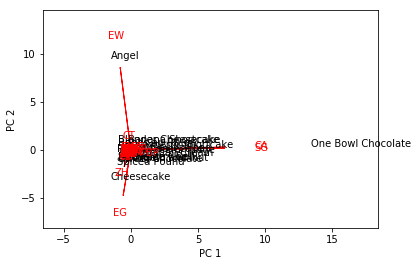

In [13]:
pca = PCA(n_components=2)
plot_PCA(pca, X, True, cakes.Cake, X.columns, biplot=True)

Here, we ran PCA on a totally unscaled version of the dataset, so we see that we're influenced by two large outliers.  The first principal component is dominated by "cocoa" and "shortening" because the "One Bowl Chocolate" cake has a huge amount of these.  The second principal component is dominated by "egg whites" because of the "Angel" foodcake recipe.

In [14]:
cake = "One Bowl Chocolate"
#cake = "Angel"
cakes[cakes.Cake==cake].transpose()

,7
Cake,One Bowl Chocolate
AE,0
BM,0
BP,2
BR,0
BS,0
CA,10
CC,0
CE,0
CI,0


In [15]:
#cakes.CA
#cakes.SG
cakes.EW
#cakes.EG

0     10
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
Name: EW, dtype: int64

Let's try mean-centering the columns first:

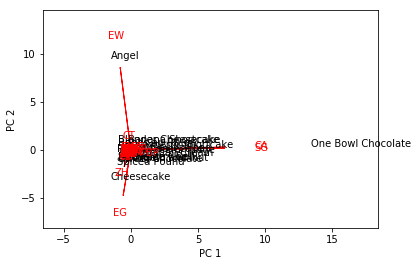

In [16]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=False)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True)

And now both center and scale to unit variance:

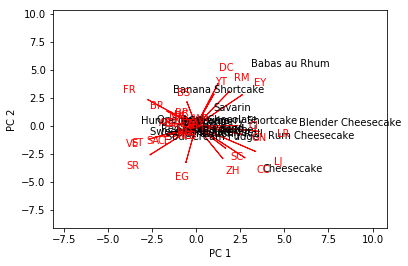

In [17]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=True)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True)

Let's look at a zoomed in version:

In [18]:
X_scaled

array([[ 0.35112344,  0.        , -0.68751406, -0.63223504, -0.24253563,
        -0.25014077, -0.49130368, -0.34956332, -0.24253563, -0.2670249 ,
         4.12310563, -0.24253563, -1.50366322, -0.35355339,  4.12310563,
        -0.42206661, -0.33333333, -0.41702883, -0.4472136 , -0.6       ,
        -0.86010608, -0.24253563, -0.24253563, -0.33333333, -0.50767308,
        -0.53452248, -0.2874733 ,  0.84047676, -0.35355339, -0.64888568,
         0.57346234, -0.50504952, -0.34174306, -0.24253563],
       [-0.35112344,  0.        , -0.68751406,  0.09354498, -0.24253563,
        -0.25014077, -0.49130368, -0.34956332, -0.24253563, -0.2670249 ,
        -0.24253563,  4.12310563, -0.9277922 ,  2.82842712, -0.24253563,
         0.36385053, -0.33333333, -0.41702883, -0.4472136 ,  0.6       ,
        -0.28242289, -0.24253563, -0.24253563,  3.66666667, -0.50767308,
        -0.53452248, -0.2874733 , -1.40545282, -0.35355339, -1.37888208,
        -0.90115511,  0.0297088 ,  1.96502261, -0.24253563],
  

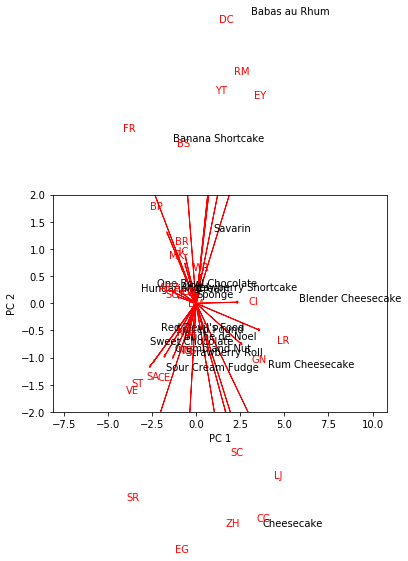

In [19]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=True)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True, y_scale=(-1, 1))

To me, it looks like cheesecakes are off to the right on the first principal component, and the second principal component is quantifying whether the cake has fruit or not...

### t-SNE

Let's switch for a moment to the handwritten digits dataset that we saw before in the notebook on k-nearest neighbors:

In [20]:
digits = load_digits()
digits_data = scale(digits.data)

labels = digits.target

In [21]:
digits_data.shape

(1797, 64)

In [22]:
pca = PCA(n_components=2)
digits_trans = pca.fit_transform(digits_data)

Let's make a plot of the first two principal components, colored and labeled by the true digit:

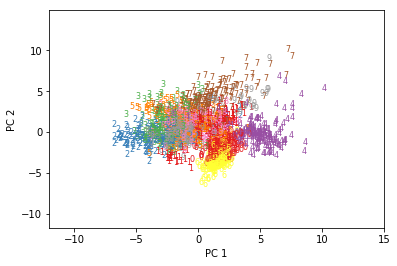

In [23]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, label in zip(digits_trans[:, 0], digits_trans[:, 1], labels):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

If our goal is visualizing the high dimensional dataset, the [t-SNE](http://lvdmaaten.github.io/tsne/) algorithm usually does a superior job of finding structure in the high-dimensional data that can be visualized in two dimensions.  There's a [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) for running t-SNE.

In [24]:
tsne = TSNE(n_components=2, verbose=True)
digits_trans = tsne.fit_transform(digits_data)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 2.377622
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.083374
[t-SNE] Error after 225 iterations: 1.083374


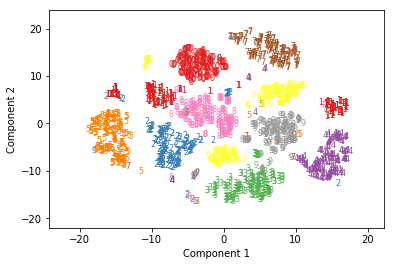

In [25]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

#for x, y, label in zip(digits_trans[labels==6, 0], digits_trans[labels==6, 1], labels[labels==6]):
for x, y, label in zip(digits_trans[:, 0], digits_trans[:, 1], labels):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

This clearly does a better job at finding the "structure" in the high-dimensional dataset.  Notice that 3, 5, and 9 end up near each other.  But there are some 1's that are closer to the 2's, and some 9's that are closer to the 7's and the 1's.

## Clustering

### Hierarchical

Now back to cakes.  We'll use some functions from scipy to run hierarchical clustering.  `linkage` calculates the distances and linkages, and `dendrogram` displays the actual tree dendrogram:

In [26]:
clusters_single = linkage(scale(X), method='single', metric="euclidean") # single, complete, average, and ward methods

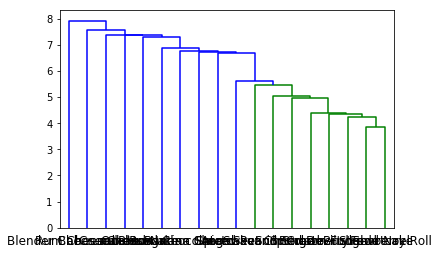

In [27]:
dendr = dendrogram(clusters_single, orientation="top", labels=list(cakes.Cake))

As ISLR says, single linkage tends to produce really unbalanced trees.  We can put the dendrogram on its side to make it easier to visualize:

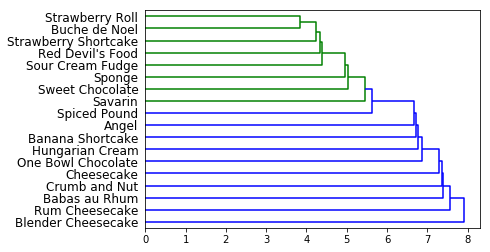

In [28]:
dendr = dendrogram(clusters_single, orientation="right", labels=list(cakes.Cake))

In [29]:
clusters_complete = linkage(scale(X), method='complete', metric="euclidean") # single, complete, average, and ward methods

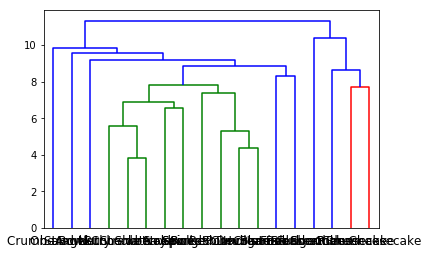

In [30]:
dendr = dendrogram(clusters_complete, orientation="top", labels=list(cakes.Cake))

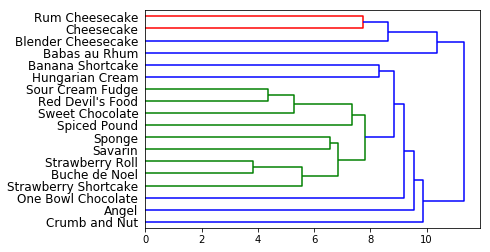

In [31]:
dendr = dendrogram(clusters_complete, orientation="right", labels=list(cakes.Cake))

In [32]:
clusters_ward = linkage(scale(X), method='ward', metric="euclidean") # single, complete, average, and ward methods

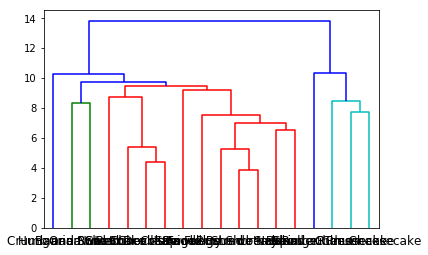

In [33]:
dendr = dendrogram(clusters_ward, orientation="top", labels=list(cakes.Cake))

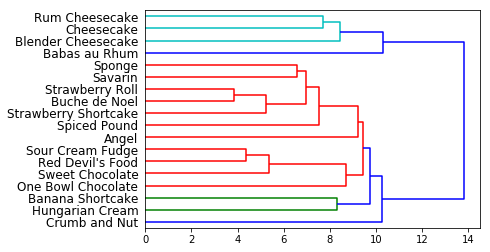

In [34]:
dendr = dendrogram(clusters_ward, orientation="right", labels=list(cakes.Cake))

The clustering is doing something sensible: the cheesecakes group together and are on their own, the chocolate cakes are together (sour cream fudge, red devil's, sweet chocolate, and one bowl chocolate), etc.

### k-Means

As a general resource, the [scikit-learn clustering page](http://scikit-learn.org/stable/modules/clustering.html) is great.  It has all the different kinds of clustering algorithms with their pros and cons.  Here, we'll focus on k-means.

In [35]:
# init can be k-means++ or random; k-means++ is just a smarter version of random that forces the
# centers to be further apart
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=300, verbose=True, n_jobs=1)

In [36]:
kmeans.fit(digits_data)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 76524.8875112
start iteration
done sorting
end inner loop
Iteration 1, inertia 73467.0332294
start iteration
done sorting
end inner loop
Iteration 2, inertia 72768.487574
start iteration
done sorting
end inner loop
Iteration 3, inertia 72215.8167568
start iteration
done sorting
end inner loop
Iteration 4, inertia 71886.0303926
start iteration
done sorting
end inner loop
Iteration 5, inertia 71678.9494457
start iteration
done sorting
end inner loop
Iteration 6, inertia 71627.6595976
start iteration
done sorting
end inner loop
Iteration 7, inertia 71603.5760398
start iteration
done sorting
end inner loop
Iteration 8, inertia 71597.837858
start iteration
done sorting
end inner loop
Iteration 9, inertia 71590.6589883
start iteration
done sorting
end inner loop
Iteration 10, inertia 71586.3043777
start iteration
done sorting
end inner loop
Iteration 11, inertia 71582.1161684
start iteration
done sorting

end inner loop
Iteration 13, inertia 70687.3316003
start iteration
done sorting
end inner loop
Iteration 14, inertia 70686.6911428
start iteration
done sorting
end inner loop
Iteration 15, inertia 70685.9151078
start iteration
done sorting
end inner loop
Iteration 16, inertia 70684.7240578
start iteration
done sorting
end inner loop
Iteration 17, inertia 70684.7240578
center shift 0.000000e+00 within tolerance 9.531250e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 75327.1700876
start iteration
done sorting
end inner loop
Iteration 1, inertia 72105.7283024
start iteration
done sorting
end inner loop
Iteration 2, inertia 71625.0594404
start iteration
done sorting
end inner loop
Iteration 3, inertia 71549.224083
start iteration
done sorting
end inner loop
Iteration 4, inertia 71497.1799397
start iteration
done sorting
end inner loop
Iteration 5, inertia 71490.3178781
start iteration
done sorting
end inner loop
Iteration 6, inertia 71479.82123

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

We can see the assigned cluster or label of each data point:

In [37]:
kmeans.labels_

array([1, 2, 2, ..., 2, 5, 5], dtype=int32)

And the cluster centers themselves:

In [38]:
kmeans.cluster_centers_.shape

(10, 64)

The "inertia" tells us the within cluster sum-of-squares, or the "sum of distances of samples to their closest cluster center."

In [39]:
kmeans.inertia_

69685.019537303378

Here, we make a plot where we color by the k-means label instead of the true label.  We can see that things are decent, but definitely more confused than with the true labels:

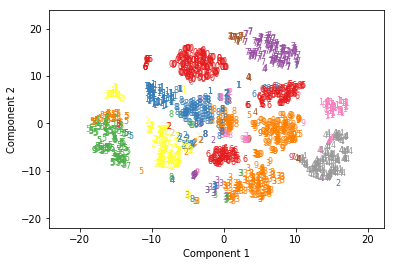

In [40]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, true_label, kmeans_label in zip(digits_trans[:, 0], digits_trans[:, 1], labels, kmeans.labels_):
    plt.text(x, y, true_label, size=8, color=plt.cm.Set1(kmeans_label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

We can call the `predict` method, which will tell us which cluster center some new data is closest too:

In [41]:
kmeans.predict(digits_data)

array([1, 2, 2, ..., 2, 5, 5], dtype=int32)

The `transform` method will transform data into the cluster distance space.  That is, how far the point is from each cluster center:

In [42]:
transformed = kmeans.transform(digits_data)
transformed[0, :]

array([  8.03195609,   3.04464697,   8.24453176,   8.00838798,
         8.00651952,   6.77430803,   9.45260551,  13.00687658,
         8.7586939 ,   7.4447937 ])

For very large datasets, there's a much faster implementation of k-means called [mini-batch k-means](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf), and a [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) for running it:

In [43]:
mb_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=100, init='k-means++', n_init=10, max_iter=300, verbose=True)

In [44]:
mb_kmeans.fit(digits_data)

Init 1/10 with method: k-means++
Inertia for init 1/10: 11605.278903
Init 2/10 with method: k-means++
Inertia for init 2/10: 12825.043606
Init 3/10 with method: k-means++
Inertia for init 3/10: 14949.432439
Init 4/10 with method: k-means++
Inertia for init 4/10: 14733.235979
Init 5/10 with method: k-means++
Inertia for init 5/10: 14229.469757
Init 6/10 with method: k-means++
Inertia for init 6/10: 15506.087850
Init 7/10 with method: k-means++
Inertia for init 7/10: 11928.813832
Init 8/10 with method: k-means++
Inertia for init 8/10: 14816.547064
Init 9/10 with method: k-means++
Inertia for init 9/10: 13837.704450
Init 10/10 with method: k-means++
Inertia for init 10/10: 13836.785811
Minibatch iteration 1/5400: mean batch inertia: 38.758204, ewa inertia: 38.758204 
Minibatch iteration 2/5400: mean batch inertia: 40.596816, ewa inertia: 38.962721 
Minibatch iteration 3/5400: mean batch inertia: 36.155957, ewa inertia: 38.650512 
Minibatch iteration 4/5400: mean batch inertia: 43.762882, 

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=10,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=True)

In [45]:
mb_kmeans.labels_

array([1, 0, 0, ..., 0, 1, 2], dtype=int32)

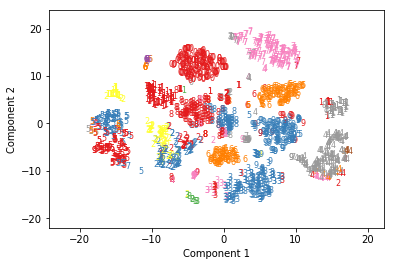

In [46]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, true_label, kmeans_label in zip(digits_trans[:, 0], digits_trans[:, 1], labels, mb_kmeans.labels_):
    plt.text(x, y, true_label, size=8, color=plt.cm.Set1(kmeans_label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

Let's see if we can re-cover the "correct" number of clusters using the silhouette statistic:

In [48]:
n_clusters = range(3, 70, 2)
silhouette_stats = []
for this_n_clusters in n_clusters:
    print("Fitting %s clusters..." % this_n_clusters)
    kmeans = KMeans(n_clusters=this_n_clusters, init='k-means++', n_init=10, max_iter=300, verbose=False, n_jobs=1)
    kmeans.fit(digits_data)
    labels = kmeans.labels_
    silhouette_stats.append(silhouette_score(digits_data, labels, metric='euclidean'))

Fitting 3 clusters...
Fitting 5 clusters...
Fitting 7 clusters...
Fitting 9 clusters...
Fitting 11 clusters...
Fitting 13 clusters...
Fitting 15 clusters...
Fitting 17 clusters...
Fitting 19 clusters...
Fitting 21 clusters...
Fitting 23 clusters...
Fitting 25 clusters...
Fitting 27 clusters...
Fitting 29 clusters...
Fitting 31 clusters...
Fitting 33 clusters...
Fitting 35 clusters...
Fitting 37 clusters...
Fitting 39 clusters...
Fitting 41 clusters...
Fitting 43 clusters...
Fitting 45 clusters...
Fitting 47 clusters...
Fitting 49 clusters...
Fitting 51 clusters...
Fitting 53 clusters...
Fitting 55 clusters...
Fitting 57 clusters...
Fitting 59 clusters...
Fitting 61 clusters...
Fitting 63 clusters...
Fitting 65 clusters...
Fitting 67 clusters...
Fitting 69 clusters...


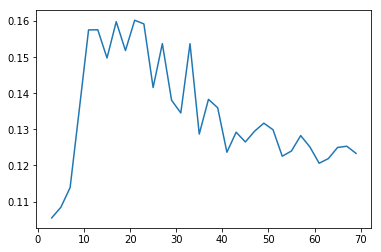

In [49]:
plt.plot(n_clusters, silhouette_stats)
plt.show()

## Text Data

In this example, we'll do dimension reduction and clustering on some text data--the 20 newsgroups dataset from last week:

In [50]:
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

In [51]:
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's only keep the 'rec.sport.baseball', 'rec.autos', 'sci.space', and 'talk.politics.guns' categories:

In [52]:
to_keep = np.where([name in [9, 7, 14, 16] for name in data_train.target])[0]
to_keep

array([    0,     4,     5, ..., 11291, 11292, 11296])

We turn the blobs of text into numeric features by using tfidf, which is basically a normalized version of the word counts:

In [53]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=25, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(np.array(data_train.data)[to_keep])
targets = data_train.target[to_keep]

Our feature matrix has 2,213 postings and 1,107 features, in sparse matrix format:

In [54]:
X_train

<2330x1107 sparse matrix of type '<class 'numpy.float64'>'
	with 64501 stored elements in Compressed Sparse Row format>

For sparse matrices, the `TruncatedSVD` class will perform PCA much, much faster than the regular `PCA` class:

In [55]:
svd = TruncatedSVD(n_components=500)

In [56]:
X_train_trans = svd.fit_transform(X_train)
X_train_trans.shape

(2330, 500)

In [57]:
svd.explained_variance_ratio_.sum()

0.81466775775682465

Let's look for four clusters in the reduced dimensionality space:

In [58]:
kmeans = MiniBatchKMeans(n_clusters=4, init_size=1000, batch_size=1000, init='k-means++', n_init=500, max_iter=1000)
#kmeans = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000)
kmeans.fit(X_train)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=1000, max_no_improvement=10, n_clusters=4,
        n_init=500, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [59]:
kmeans.labels_

array([3, 1, 1, ..., 1, 3, 1], dtype=int32)

In [60]:
data_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [61]:
pd.crosstab(index=targets, columns=kmeans.labels_, rownames=['True'], colnames=['Predicted'])

Predicted,0,1,2,3
True,,,,
7,30,306,0,258
9,459,138,0,0
14,44,326,221,2
16,10,532,3,1


Let's look at the cluster centers, and find the top 10 "directions" or terms that correspond to each:

In [62]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i)
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 year
 team
 think
 game
 just
 good
 baseball
 games
 like
 time
Cluster 1:
 people
 gun
 don
 like
 just
 right
 make
 guns
 think
 know
Cluster 2:
 space
 nasa
 launch
 shuttle
 moon
 orbit
 earth
 lunar
 data
 station
Cluster 3:
 car
 cars
 engine
 like
 price
 new
 dealer
 good
 just
 thanks
